In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Function to load CSI data and metadata
def load_csi_dataset(base_path):
    data = []
    labels = []
    for figure in os.listdir(base_path):
        figure_path = os.path.join(base_path, figure)
        if not os.path.isdir(figure_path):
            continue
        for pattern in os.listdir(figure_path):
            pattern_path = os.path.join(figure_path, pattern)
            config_path = os.path.join(pattern_path, "config0001")
            if not os.path.isdir(config_path):
                continue
            # Load real and imaginary CSI
            real_file = os.path.join(config_path, "config0001_csi_real_log.csv")
            imag_file = os.path.join(config_path, "config0001_csi_imag_log.csv")
            metadata_file = os.path.join(config_path, "config0001.csv")
            
            csi_real = pd.read_csv(real_file, header=None).values
            csi_imag = pd.read_csv(imag_file, header=None).values
            metadata = pd.read_csv(metadata_file)
            
            # Combine into complex CSI matrix
            csi_data = csi_real + 1j * csi_imag
            
            # Extract bpm
            bpm_row = metadata[metadata['Var1'] == 'bpm']
            bpm = float(bpm_row['Value'].values[0])  # Convert to float
            
            data.append(csi_data)
            labels.append(bpm)
    return np.array(data), np.array(labels)

base_path = 'Dataset/BreathRate'  
# Load dataset
csi_data, labels = load_csi_dataset(base_path)
print(f"Loaded CSI Dataset: {csi_data.shape}")
print(f"Labels Shape: {labels.shape}")
print(f"Sample Labels: {labels[:50]}")





Loaded CSI Dataset: (28, 600, 1026)
Labels Shape: (28,)
Sample Labels: [17. 23. 13. 21.  4. 19. 27.  9. 24. 14. 16. 29. 30. 11. 26. 15. 12. 28.
  8. 22. 25.  6.  5.  3. 20.  7. 10. 18.]


In [11]:
# Extract bpm from the metadata
bpm_row = metadata[metadata['Var1'] == 'bpm']
bpm = bpm_row['Value'].values[0]  # Extract the bpm value
print(f"Extracted BPM: {bpm}")


NameError: name 'metadata' is not defined

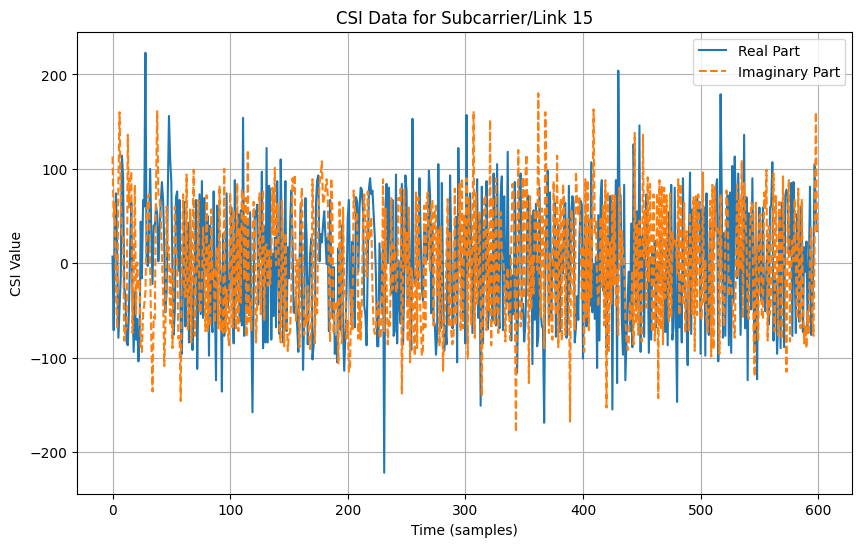

In [3]:
# Select a sample CSI matrix (e.g., the first one in the dataset)
sample_csi = csi_data[0]  # Shape: (600, 1026)

# Choose a single subcarrier or link (e.g., 0th index)
subcarrier_index = 15
real_part = sample_csi[:, subcarrier_index].real
imag_part = sample_csi[:, subcarrier_index].imag

# Plot real and imaginary parts
plt.figure(figsize=(10, 6))
plt.plot(real_part, label="Real Part")
plt.plot(imag_part, label="Imaginary Part", linestyle="--")
plt.title(f"CSI Data for Subcarrier/Link {subcarrier_index}")
plt.xlabel("Time (samples)")
plt.ylabel("CSI Value")
plt.legend()
plt.grid()
plt.show()


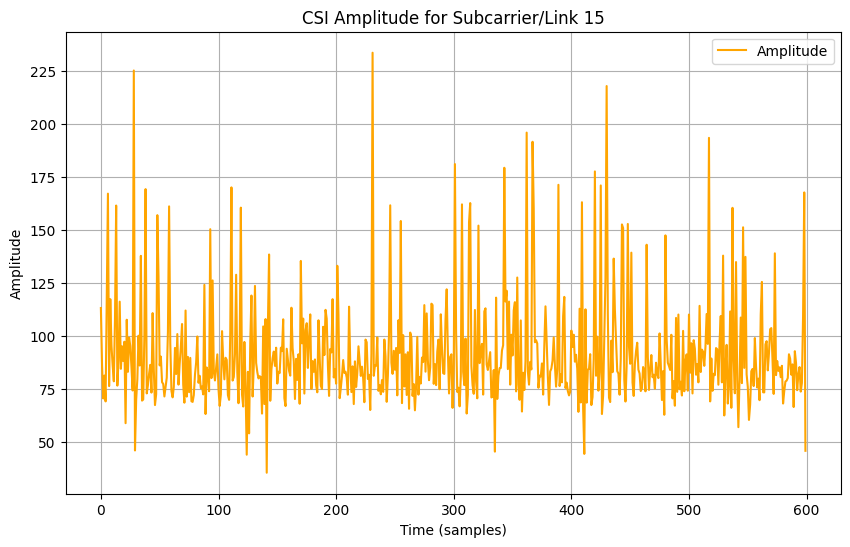

In [4]:
# Calculate amplitude
amplitude = np.abs(sample_csi)

# Plot the amplitude for the selected subcarrier/link
plt.figure(figsize=(10, 6))
plt.plot(amplitude[:, subcarrier_index], label="Amplitude", color="orange")
plt.title(f"CSI Amplitude for Subcarrier/Link {subcarrier_index}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()


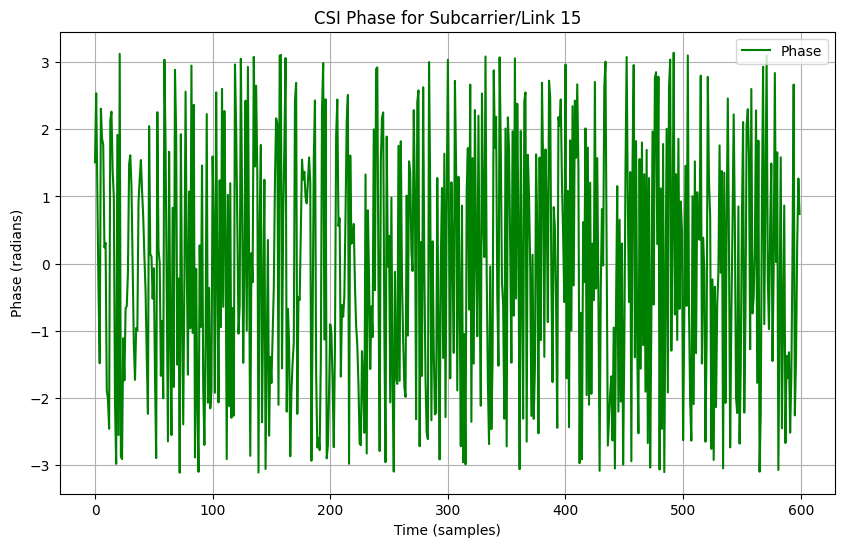

In [5]:
# Calculate phase
phase = np.angle(sample_csi)

# Plot the phase for the selected subcarrier/link
plt.figure(figsize=(10, 6))
plt.plot(phase[:, subcarrier_index], label="Phase", color="green")
plt.title(f"CSI Phase for Subcarrier/Link {subcarrier_index}")
plt.xlabel("Time (samples)")
plt.ylabel("Phase (radians)")
plt.grid()
plt.legend()
plt.show()


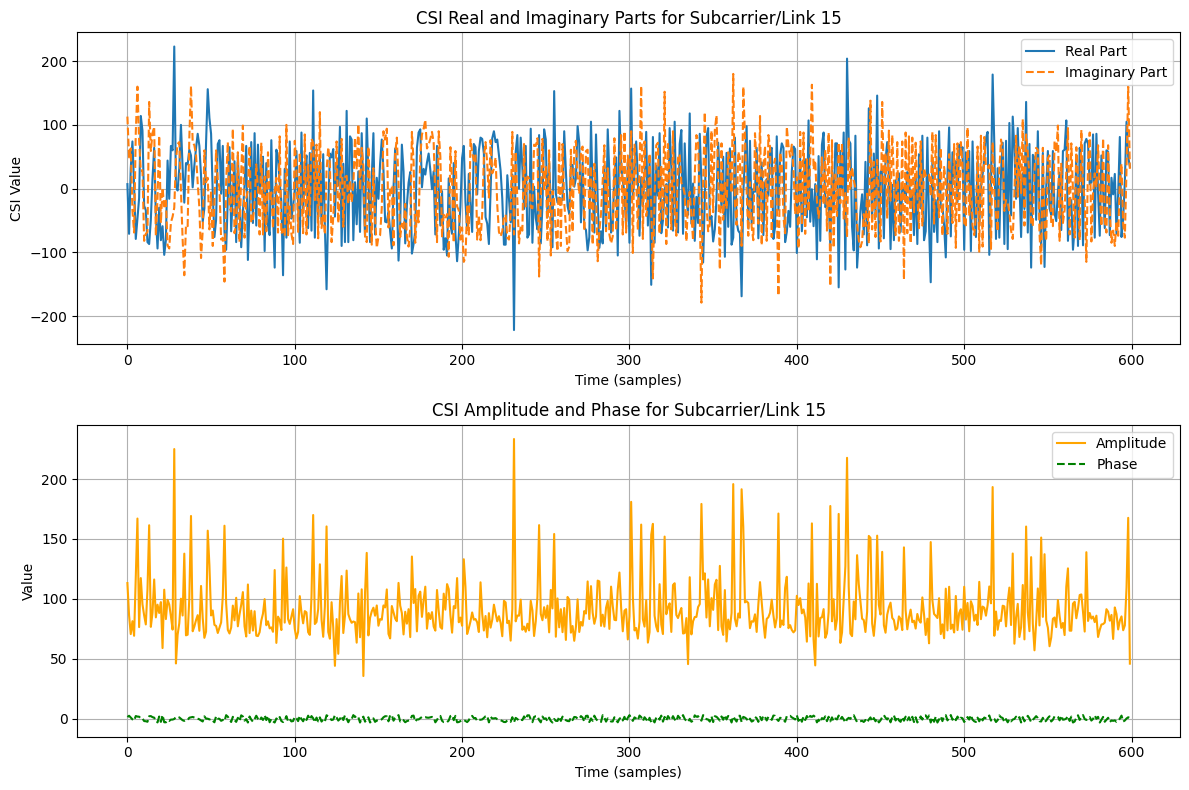

In [6]:
plt.figure(figsize=(12, 8))

# Real and Imaginary parts
plt.subplot(2, 1, 1)
plt.plot(real_part, label="Real Part")
plt.plot(imag_part, label="Imaginary Part", linestyle="--")
plt.title(f"CSI Real and Imaginary Parts for Subcarrier/Link {subcarrier_index}")
plt.xlabel("Time (samples)")
plt.ylabel("CSI Value")
plt.legend()
plt.grid()

# Amplitude and Phase
plt.subplot(2, 1, 2)
plt.plot(amplitude[:, subcarrier_index], label="Amplitude", color="orange")
plt.plot(phase[:, subcarrier_index], label="Phase", color="green", linestyle="--")
plt.title(f"CSI Amplitude and Phase for Subcarrier/Link {subcarrier_index}")
plt.xlabel("Time (samples)")
plt.ylabel("Value")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
# Preprocessing and Feature Extraction
from scipy.signal import butter, filtfilt

def preprocess_and_extract_features(csi_data):
    # Initialize containers
    amplitudes = []
    phases = []
    for sample in csi_data:
        # Calculate amplitude and phase
        amplitude = np.abs(sample)
        phase = np.angle(sample)
        
        # Smoothen amplitude using Butterworth filter
        fs = 10  # Sampling frequency
        cutoff = 0.1  # Cutoff frequency
        b, a = butter(5, cutoff / (0.5 * fs), btype='low', analog=False)
        amplitude_smoothed = filtfilt(b, a, amplitude, axis=0)
        
        amplitudes.append(amplitude_smoothed)
        phases.append(phase)
    
    return np.array(amplitudes), np.array(phases)

amplitudes, phases = preprocess_and_extract_features(csi_data)
print(f"Amplitudes Shape: {amplitudes.shape}")
print(f"Phases Shape: {phases.shape}")


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout

# Build BiLSTM model
def build_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.3),
        Dense(1, activation='linear')  # Use 'softmax' for classification
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Adjust for classification if needed
    return model

# Input shape: (time_steps, features)
time_steps = amplitudes.shape[1]
features = amplitudes.shape[2]
model = build_bilstm_model((time_steps, features))
model.summary()


In [ ]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(amplitudes, labels, test_size=0.2, random_state=42)

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)


In [ ]:
# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss (MSE): {loss}")
print(f"Test MAE: {mae}")


In [ ]:
# Predict breathing rates
y_pred = model.predict(X_test)

# Display some predictions vs ground truth
for i in range(1):
    print(f"Ground Truth: {y_test[i]:.2f} BPM, Predicted: {y_pred[i][0]:.2f} BPM")


In [ ]:
import matplotlib.pyplot as plt

# Plot predicted vs true values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True Values (BPM)", marker='o')
plt.plot(y_pred, label="Predicted Values (BPM)", marker='x')
plt.title("Breathing Rate: True vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Breathing Rate (BPM)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot histogram of prediction errors
errors = y_pred.flatten() - y_test
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=20, edgecolor='k')
plt.title("Histogram of Prediction Errors")
plt.xlabel("Prediction Error (BPM)")
plt.ylabel("Frequency")
plt.grid()
plt.show()


In [ ]:
# Select a single sample for prediction
sample = X_test[0:1]  # Take the first sample
true_value = y_test[0]

# Predict the breathing rate
predicted_value = model.predict(sample)[0][0]
print(f"Real-Time Prediction:")
print(f"True Breathing Rate: {true_value:.2f} BPM")
print(f"Predicted Breathing Rate: {predicted_value:.2f} BPM")


In [ ]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
